In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cirq
from mitiq import zne, benchmarks
from mitiq.benchmarks import random_circuits
import math

def execute(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real


circuit: cirq.Circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]

true_value = execute(circuit, noise_level=0.0)       # Ideal quantum computer.
noisy_value = execute(circuit)                       # Noisy quantum computer.
zne_value = zne.execute_with_zne(circuit, execute)   # Noisy quantum computer + Mitiq.

print(f"Error (w/o  Mitiq): %0.4f" %abs((true_value - noisy_value) / true_value))
print(f"Error (with Mitiq): %0.4f" %abs((true_value - zne_value) / true_value))
print(circuit)

Error (w/o  Mitiq): 0.0648
Error (with Mitiq): 0.0011
0: ───X^0───X^0.5───Y^0───Y^-0.5───X^-0.5───Y^0.5───X^-0.5───Y^0───Y^-0.5───X^0───Y^0.5───X^0───Y───X^0───Y───X^0───Y───X───X^0───X^0.5───Y^0───X^0───Y^0.5───X^0.5───Y^0.5───Y^0.5───X^0───X^-0.5───Y^0.5───X───Y^-0.5───Y───X^-0.5───Y^-0.5───X^-0.5───X^0.5───Y^0───Y^0.5───X^0.5───Y^0.5───Y^-0.5───X^-0.5───Y^0.5───X───Y^-0.5───Y^0.5───X^0───X───Y^0.5───X^0.5───Y^-0.5───Y^-0.5───X^0.5───X^0───X^0.5───Y^-0.5───Y───X^0───Y───X^0───X───Y^0───Y───X───X───Y^-0.5───X^-0.5───Y^0.5───Y^-0.5───X^-0.5───Y^-0.5───X^-0.5───Y^0.5───Y^0.5───X^0.5───Y^-0.5───X^0───Y^-0.5───X^0───X^-0.5───Y^-0.5───Y^0.5───X^-0.5───Y^-0.5───X^0───Y^0.5───X^-0.5───X^-0.5───Y^0.5───X^0.5───Y^0.5───X^0───X^-0.5───Y^-0.5───Y───X^0.5───Y^0.5───X^0.5───Y^0.5───Y^0.5───X^-0.5───Y^0.5───X^0.5───Y^0.5───


In [7]:
circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]
print(random_circuits.rand_circuit_zne(n_qubits=1, depth=10, trials=10, noise=0.01))

(array([0.5, 0.5, 1. , 0. , 0.5, 0.5, 0.5, 0. , 0.5, 0. ]), array([0.49999994, 0.49999994, 0.93719411, 0.0628056 , 0.49999985,
       0.49999994, 0.49999994, 0.06280562, 0.49999994, 0.06280561]), array([4.99999940e-01, 5.00000089e-01, 9.99008775e-01, 9.90845263e-04,
       5.00000030e-01, 5.00000268e-01, 4.99999911e-01, 9.90889966e-04,
       5.00000238e-01, 9.90867615e-04]))


In [8]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory

# method: scale noise by 1 and 2, then extrapolate linearly to the zero noise limit.
linear_fac = LinearFactory(scale_factors=[1.0, 2.0])

# method: scale noise by 1, 2 and 3, then evaluate the Richardson extrapolation.
richardson_fac = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])

# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)

In [9]:
from mitiq.zne.zne import execute_with_zne

exact = true_value

zne_expval = execute_with_zne(circuit, execute, factory=linear_fac)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute, factory=richardson_fac)
print(f"Error with richardson_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute, factory=poly_fac)
print(f"Error with poly_fac: {abs(exact - zne_expval):.4f}")

Error with linear_fac: 0.0084
Error with richardson_fac: 0.0011
Error with poly_fac: 0.0018


In [10]:
factory_with_shots = LinearFactory(scale_factors=[1.0, 2.0], shot_list=[100, 200])
zne_expval = execute_with_zne(circuit, execute, factory=linear_fac)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

Error with linear_fac: 0.0084


In [11]:
factory_with_shots = LinearFactory(scale_factors=[1.0, 2.0], shot_list=[1000, 2000])
zne_expval = execute_with_zne(circuit, execute, factory=linear_fac)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

Error with linear_fac: 0.0084


In [12]:
um_vals = []
zne_vals = []
# num_cliffords = [10, 50]
num_cliffords = [10, 50, 100, 150, 200, 250]
for nc in num_cliffords:
    circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=nc)[0]
    um_expval = execute(circuit)
    zne_expval = execute_with_zne(circuit, execute, factory=poly_fac)
    um_vals.append(um_expval)
    zne_vals.append(zne_expval)

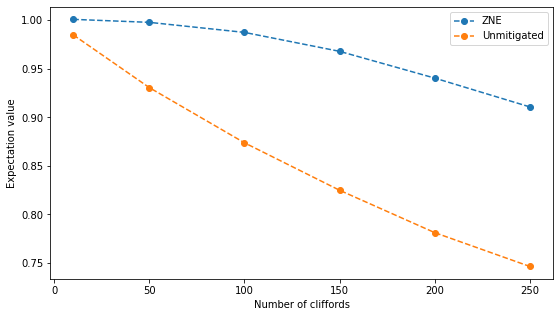

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# average_zne_values = np.average(np.array(zne_values).reshape((len(nlayers_values), ntrials)), axis=1)
# average_noisy_values = np.average(np.array(noisy_values).reshape((len(nlayers_values), ntrials)), axis=1)

# plt.rcParams.update({"font.family": "serif", "font.size": 16})
plt.figure(figsize=(9, 5))

plt.plot(num_cliffords, zne_vals, "--o", label="ZNE")
plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Number of cliffords")
plt.ylabel("Expectation value")

plt.legend()
# plt.savefig('images/zne.png', dpi=300, facecolor='white')
plt.show();

### Questions:
- Does readout error change based on the circuit or, rather, what changes readout errors?
- What is the difference between random circuits and randomized benchmarking circuits?
  - From @qryan: random_circuits.py will be deprecated soon. It has a function for running zne with randomized benchmarking circuits but shouldn't really be in Mitiq. https://github.com/unitaryfund/mitiq/pull/1047 is moving towards more proper benchmarks
- Does ZNE only help to correct [depolarizing noise](https://en.wikipedia.org/wiki/Quantum_depolarizing_channel) or does it help with [other types of noise](https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html)?
  - The [paper](https://arxiv.org/pdf/2005.10921.pdf) seems to suggest that other noise, such as calibration noise, can be corrected. 
  - Unitary folding is not appropriate to scale state preparation and measurement (SPAM) errors since those are independent of circuit depth. Instead it is good for scaling incoherent noise.
- Has anyone tried using ZNE for gate tomography? It seems general enough that if you only amplified a specific set of gates, you could extrapolate back to zero noise.
- Ranendu says that ZNE doesn't scale as well as CDR
- Given a limited T1, T2 what are the best results we can achieve?
- Depending on the error produced would it be possible to have a unitary that could be applied at the end before measurement that encapsulates the zero-noise extrapolation and essentially corrects the results on-device?
- It might be interesting to compare the cost in overall shot count of PEC to total shot count of error scaling in ZNE (or CDR).
- An open question from the Mitiq paper was whether stacking error mitigation techniques would be useful (e.g. PEC, then ZNE).
- Should readout error mitigation be applied to the different techniqes; especially ZNE since the Mitiq paper talks about readout errors causing issues in extrapolation?
- Still an open question is when ZNE is effective; ex. situation is one where as noise is increased the expectation value stays constant.
- Which circuit is a good circuit to analyze?

# QPE

In [14]:
from qpe import generate_qpe_circuit
from cirq import ZPowGate
import numpy as np

from qpe import generate_qpe_circuit
phase = 5/16
U = ZPowGate(exponent=phase*2)
circuit, t, control, target = generate_qpe_circuit(U, 1, t=4)
# circuit, t, control, target = generate_qpe_circuit(U, 1, eps=0.3)
print(f't = {t}')
# print(dir(circuit))
print(f'depth = {len(circuit)}')

# Measure and print the results
circuit_with_measurement = circuit.copy()
circuit_with_measurement.append(cirq.measure(*control, key='result'))

s=cirq.Simulator()
print('Sampling the circuit:')
samples=s.run(circuit_with_measurement, repetitions=1000)
# Print a histogram of results
counts = samples.histogram(key='result')
print(counts)
most_freq_bitstring = sorted(counts, key=lambda k: counts[k], reverse=True)[0]
print(f'𝜙 = {most_freq_bitstring/2**t}')
#010 -> ZZZ: 1*-1*1 = -1
#100 -> ZZZ: -1*1*1 = -1
#011 -> ZZZ: 1*-1*-1 = 1

t = 4
depth = 17
Sampling the circuit:
Counter({5: 1000})
𝜙 = 0.3125


In [15]:
def execute_phi_observable(circuit: cirq.Circuit, noise_level: float = 0.01) -> float:
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    samples = cirq.DensityMatrixSimulator().run(noisy_circuit, repetitions=1000)
    counts = samples.histogram(key='result')
    print(counts)
    most_freq_bitstring = sorted(counts, key=lambda k: counts[k], reverse=True)[0]    
    return most_freq_bitstring

In [16]:
print(execute_phi_observable(circuit))
zne_value = zne.execute_with_zne(circuit, execute_phi_observable)
print(zne_value)

ValueError: Circuit has no measurements to sample.

### Trying out the above w/ different extrapolation methods

In [17]:
from mitiq.zne.zne import execute_with_zne

exact = 5

zne_expval = execute_with_zne(circuit, execute_phi_observable, factory=linear_fac)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_phi_observable, factory=richardson_fac)
print(f"Error with richardson_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_phi_observable, factory=poly_fac)
print(f"Error with poly_fac: {abs(exact - zne_expval):.4f}")

ValueError: Circuit has no measurements to sample.

In [18]:
from typing import Tuple
from mitiq import Executor, Observable, PauliString, MeasurementResult
from mitiq.interface import mitiq_cirq
from cirq import X, I

# t = 3
# circuit = cirq.Circuit()
# qubits = [cirq.LineQubit(i) for i in range(t)]
# circuit.append(X(qubits[0]))
# for i in range(1, t):
#     circuit.append(I(qubits[i]))
# print(circuit)

paulis = []
paulis.append(PauliString("I", coeff=0.5*(2**t-1)))
for p in range(t):    
    paulis.append(PauliString("Z", coeff=0.5*-2**(t-1-p), support=(p,)))
obs = Observable(*paulis)
print(obs)
# print(obs.matrix())

# zne_value = zne.execute_with_zne(circuit, execute, obs)
# print(zne_value)

def simulate(circuit: cirq.Circuit) -> np.ndarray:
    return mitiq_cirq.compute_density_matrix(circuit, noise_level=(0.0,))

def sample_bitstrings(
    circuit: cirq.Circuit,
    noise_model: cirq.NOISE_MODEL_LIKE = cirq.amplitude_damp,  # type: ignore
    noise_level: Tuple[float] = (0.01,),
    sampler: cirq.Sampler = cirq.DensityMatrixSimulator(),
    shots: int = 8192,
) -> MeasurementResult:
    if sum(noise_level) > 0:
        circuit = circuit.with_noise(noise_model(*noise_level))  # type: ignore

    result = sampler.run(circuit, repetitions=shots)
    print(result.measurements.keys())
    return MeasurementResult(
        result=np.column_stack(list(result.measurements.values())),
        qubit_indices=tuple(
            int(q) for k in result.measurements.keys() for q in k.split(",")
        ),
    )

def execute_noisy(circuit: cirq.Circuit) -> MeasurementResult:
#     return mitiq_cirq.compute_density_matrix(circuit, noise_level=(0.01,))
#     noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
#     samples = cirq.DensityMatrixSimulator().run(noisy_circuit, repetitions=1000)
#     return samples
#     circuit = circuit.copy()
#     circuit.append(cirq.ops.measure_each(*control))
#     circuit.append(cirq.measure(*control, key='0,1,2,3'))
    return mitiq_cirq.sample_bitstrings(circuit, noise_level=(0.01,))
#     return mitiq_cirq.execute_with_shots_and_depolarizing_noise(circuit, cirq.PauliSum.from_pauli_strings(paulis), 0.01, 1000)

executor = Executor(mitiq_cirq.compute_density_matrix)
# print(obs.expectation(circuit, execute=mitiq_cirq.sample_bitstrings))
# zne_value = obs.expectation(circuit, execute=mitiq_cirq.compute_density_matrix).real
# zne_value = obs.expectation(circuit, execute=mitiq_cirq.sample_bitstrings).real
zne_value = obs.expectation(circuit, execute=simulate).real
# zne_value = zne.execute_with_zne(circuit, executor, obs).real
print(zne_value)

# circuits = obs.measure_in(circuit)
zne_value = obs.expectation(circuit, execute=execute_noisy).real
print(zne_value)

zne_value = zne.execute_with_zne(circuit, execute_noisy, obs).real
zne_value = max(min(zne_value, 2**t - 1), -2**t - 1)
print(zne_value)
#00101
#1 1 -1 1 -1 -> 00101

(7.5+0j)*I + (-4+0j)*Z(0) + (-2+0j)*Z(1) + -Z(2) + (-0.5+0j)*Z(3)
4.9999987871790434
5.177001953125
4.944702148437497


In [19]:
from mitiq.zne.zne import execute_with_zne

exact = 5

num_experiments=100
zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=linear_fac, num_to_average=num_experiments)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=richardson_fac, num_to_average=num_experiments)
print(f"Error with richardson_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=poly_fac, num_to_average=num_experiments)
print(f"Error with poly_fac: {abs(exact - zne_expval):.4f}")

KeyboardInterrupt: 

In [421]:
from mitiq.zne.zne import execute_with_zne

exact = 5

num_experiments=100
zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=linear_fac, num_to_average=num_experiments)
print(f"Error with linear_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=richardson_fac, num_to_average=num_experiments)
print(f"Error with richardson_fac: {abs(exact - zne_expval):.4f}")

zne_expval = execute_with_zne(circuit, execute_noisy, obs, factory=poly_fac, num_to_average=num_experiments)
print(f"Error with poly_fac: {abs(exact - zne_expval):.4f}")

Error with linear_fac: 1.4449
Error with richardson_fac: 1.7132
Error with poly_fac: 0.7073


In [379]:
from cirq import DensityMatrixSimulator
SIMULATOR = DensityMatrixSimulator()

def execute_noise_model(circuit: cirq.Circuit, noise: 'cirq.NOISE_MODEL_LIKE') -> np.ndarray:
    circuit = circuit.with_noise(noise)
    rho = SIMULATOR.simulate(circuit).final_density_matrix
    return rho

In [399]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from tqdm import tqdm

noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.01, 0.05, 0.1]
results = {}
for nm in noise_models:
    exp_vals = []
    for noise_level in tqdm(noise_levels):
        noise = None
        if nm in [depolarize, phase_flip, bit_flip]:
            noise = nm(p=noise_level)
        else:
            noise = nm(gamma=noise_level)

        execute_with_noise = partial(execute_noise_model, noise=noise)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs, num_to_average=100).real
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals

100%|██████████| 3/3 [03:12<00:00, 64.28s/it]


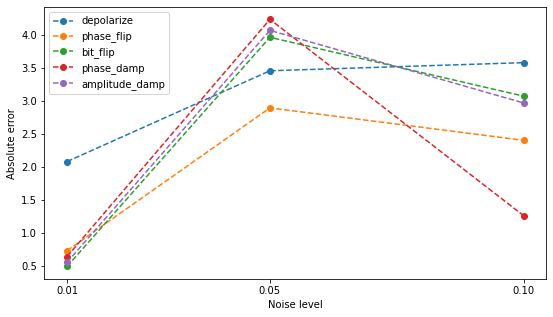

In [400]:
plt.figure(figsize=(9, 5))
for nm, exp_vals in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
plt.savefig('images/zne_noise_models.png', dpi=300, facecolor='white')
plt.show();

In [403]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from tqdm import tqdm

noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.01, 0.03, 0.06, 0.1]
results = {}
for nm in noise_models:
    exp_vals = []
    for noise_level in tqdm(noise_levels):
        noise = None
        if nm in [depolarize, phase_flip, bit_flip]:
            noise = nm(p=noise_level)
        else:
            noise = nm(gamma=noise_level)

        execute_with_noise = partial(execute_noise_model, noise=noise)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs, num_to_average=50).real
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals

100%|██████████| 4/4 [02:18<00:00, 34.53s/it]


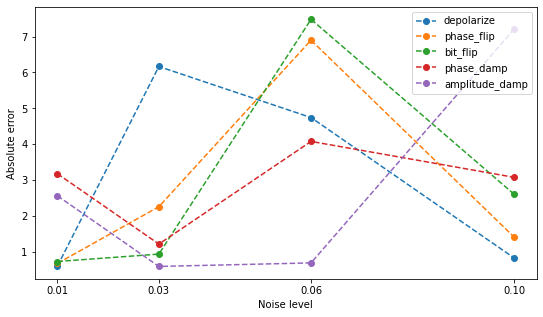

In [404]:
plt.figure(figsize=(9, 5))
for nm, exp_vals in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
plt.savefig('images/zne_noise_models3.png', dpi=300, facecolor='white')
plt.show();

In [474]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from tqdm import tqdm

noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.01, 0.03, 0.06, 0.1]
results = {}
for nm in noise_models:
    exp_vals = []
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=1024)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs).real
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals

100%|██████████| 4/4 [00:21<00:00,  5.46s/it]


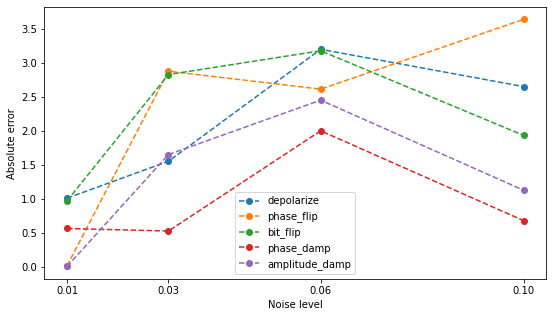

In [475]:
plt.figure(figsize=(9, 5))
for nm, exp_vals in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
plt.savefig('images/zne_noise_models3.png', dpi=300, facecolor='white')
plt.show();

In [26]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from mitiq.zne import RichardsonFactory
from tqdm import tqdm

num_to_average = 25
shots = 1024
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.02, 0.04, 0.06, 0.08, 0.1] #TODO: rename to noise_strengths
scale_factors = [1.0, 3.0, 5.0, 7.0]
results = {}

for nm in noise_models:
    exp_vals = []
    all_exp_values = {}
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
        factory = RichardsonFactory(scale_factors=scale_factors)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
        all_exp_vals = factory.get_expectation_values()
        all_exp_values[noise_level] = np.real(all_exp_vals)
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals, all_exp_values

100%|██████████| 5/5 [13:04<00:00, 156.95s/it]


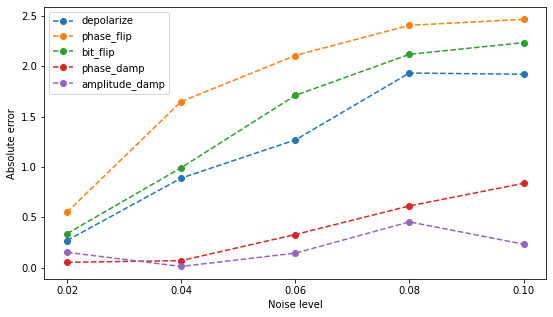

In [27]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models.png', dpi=300, facecolor='white')
plt.show();

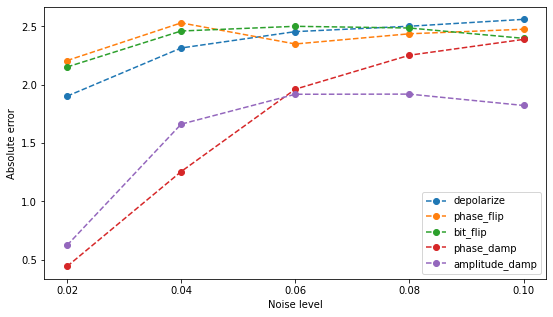

In [528]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

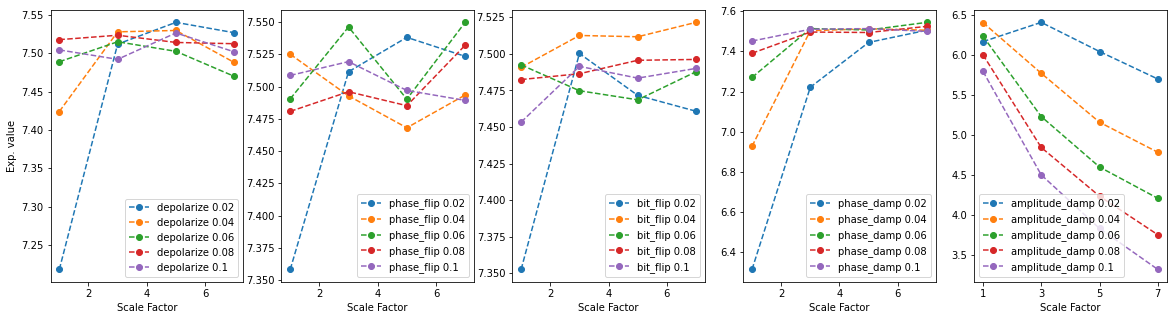

In [529]:
# plt.figure(figsize=(9, 5))
fig, ax = plt.subplots(1, len(noise_levels), figsize=(20, 5))
for i, item in enumerate(results.items()):
    nm, (exp_vals, all_exp_values) = item
    for nl, all_exp_vals in all_exp_values.items():
        ax[i].plot(scale_factors, all_exp_vals, "--o", label=f"{nm} {nl}")
        ax[i].set_xlabel("Scale Factor")
        ax[i].legend()

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")
ax[0].set_ylabel("Exp. value")
plt.xticks(scale_factors)

# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

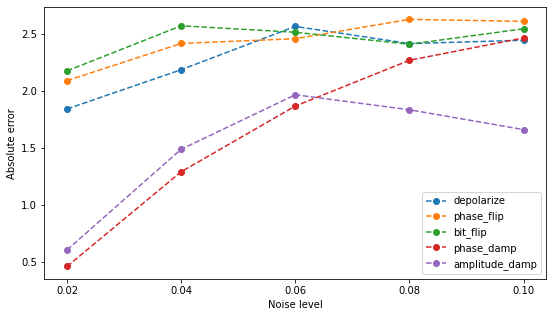

In [525]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

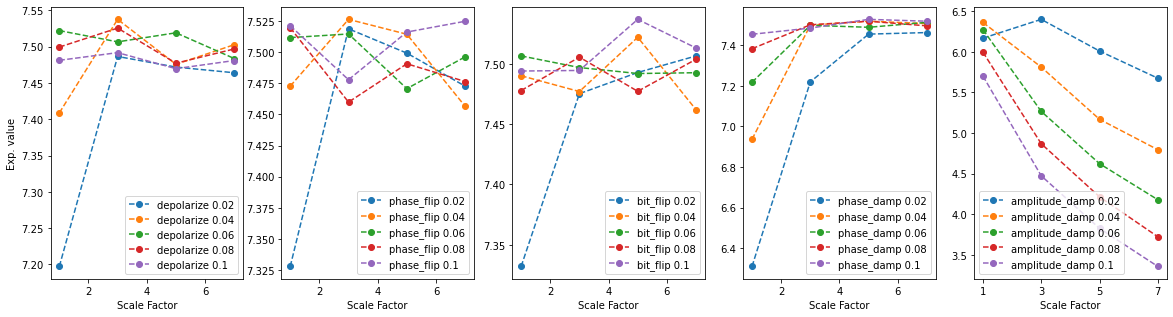

In [526]:
# plt.figure(figsize=(9, 5))
fig, ax = plt.subplots(1, len(noise_levels), figsize=(20, 5))
for i, item in enumerate(results.items()):
    nm, (exp_vals, all_exp_values) = item
    for nl, all_exp_vals in all_exp_values.items():
        ax[i].plot(scale_factors, all_exp_vals, "--o", label=f"{nm} {nl}")
        ax[i].set_xlabel("Scale Factor")
        ax[i].legend()

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")
ax[0].set_ylabel("Exp. value")
plt.xticks(scale_factors)

# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

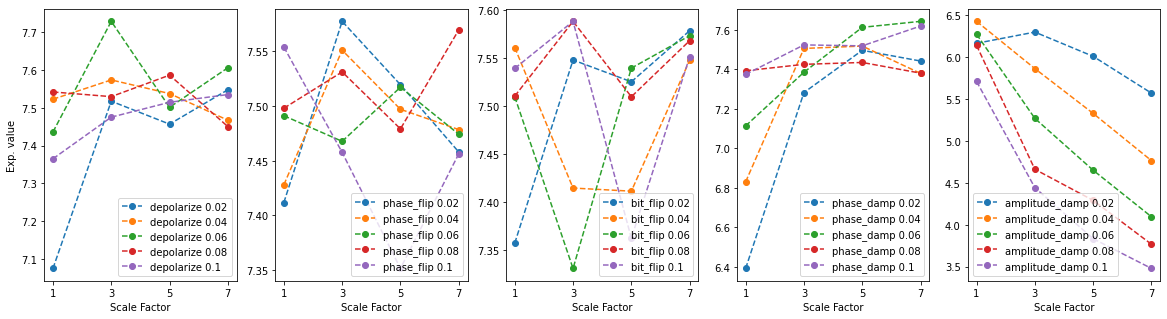

In [523]:
# plt.figure(figsize=(9, 5))
fig, ax = plt.subplots(1, len(noise_levels), figsize=(20, 5))
for i, item in enumerate(results.items()):
    nm, (exp_vals, all_exp_values) = item
    for nl, all_exp_vals in all_exp_values.items():
        ax[i].plot(scale_factors, all_exp_vals, "--o", label=f"{nm} {nl}")
        ax[i].set_xlabel("Scale Factor")
        ax[i].set_xticks(scale_factors)
        ax[i].legend()

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")
ax[0].set_ylabel("Exp. value")

# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

In [32]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from mitiq.zne import RichardsonFactory
from tqdm import tqdm

num_to_average = 24
shots = 128
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.02, 0.04, 0.06, 0.08, 0.1] #TODO: rename to noise_strengths
scale_factors = [1.0, 3.0, 5.0, 7.0]
results = {}

for nm in noise_models:
    exp_vals = []
    all_exp_values = {}
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
        factory = RichardsonFactory(scale_factors=scale_factors)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
        all_exp_vals = factory.get_expectation_values()
        all_exp_values[noise_level] = np.real(all_exp_vals)
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals, all_exp_values

100%|██████████| 5/5 [02:53<00:00, 34.74s/it]


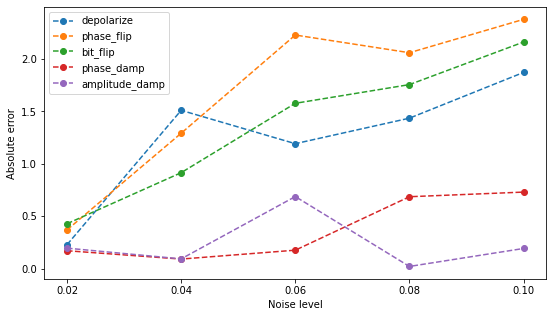

In [33]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

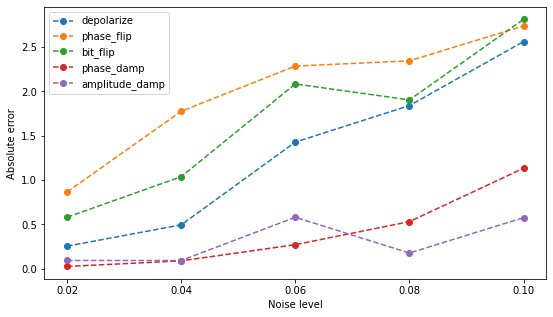

In [31]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

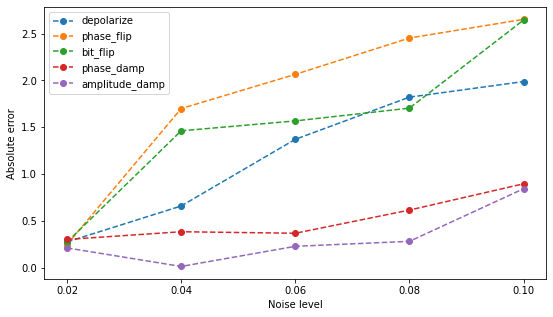

In [29]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

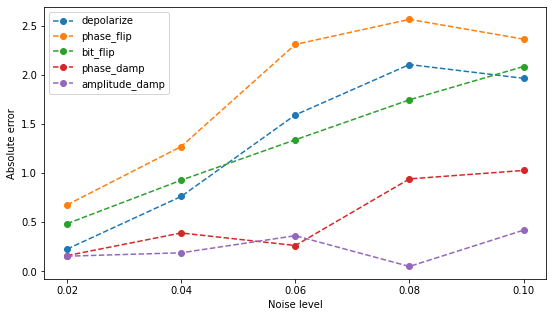

In [25]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

# plt.plot(num_cliffords, um_vals, "--o", label="Unmitigated")

plt.xlabel("Noise level")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
# plt.savefig('images/zne_noise_models4.png', dpi=300, facecolor='white')
plt.show();

# Qiskit

In [87]:
import qiskit
from qiskit.test.ibmq_mock import mock_get_backend
from qiskit.providers.aer.noise import NoiseModel

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [10]:
USE_REAL_HARDWARE = False

qreg, creg = qiskit.QuantumRegister(1), qiskit.ClassicalRegister(1)
circuit = qiskit.QuantumCircuit(qreg, creg)
for _ in range(10):
    circuit.x(qreg)
circuit.measure(qreg, creg)
print(circuit)

      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q0_0: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤M├
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└╥┘
c0: 1/═══════════════════════════════════════════════════╩═
                                                         0 


In [109]:
if qiskit.IBMQ.stored_account() and not provider:
    provider = qiskit.IBMQ.load_account()
    
if USE_REAL_HARDWARE:    
    backend = provider.get_backend("ibmq_qasm_simulator")  # Set quantum computer here!
else:
    # Default to a simulator.
    backend = qiskit.Aer.get_backend("qasm_simulator"),


def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    if USE_REAL_HARDWARE:
        # Run the circuit on hardware
        job = qiskit.execute(
            experiments=circuit,
            backend=backend,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots
        )
    else:
        # Simulate the circuit with noise
#         noise_model = initialized_depolarizing_noise(noise_level=0.02)
        backend = provider.get_backend('ibmq_armonk')
        noise_model = NoiseModel.from_backend(properties)
        job = qiskit.execute(
            experiments=circuit,
            backend=qiskit.Aer.get_backend("qasm_simulator"),
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    if counts.get("0") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("0") / shots
    return expectation_value

In [108]:
unmitigated = ibmq_executor(circuit)
mitigated = zne.execute_with_zne(circuit, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

Unmitigated result 0.904
Mitigated result 0.970


In [98]:
linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
mitigated = zne.execute_with_zne(circuit, ibmq_executor, factory=linear_factory)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 0.970


In [17]:
backend = provider.get_backend('ibmq_armonk')

In [25]:
properties = backend.properties()
dir(properties)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply_prefix',
 '_data',
 '_gates',
 '_qubits',
 'backend_name',
 'backend_version',
 'faulty_gates',
 'faulty_qubits',
 'frequency',
 'from_dict',
 'gate_error',
 'gate_length',
 'gate_property',
 'gates',
 'general',
 'is_gate_operational',
 'is_qubit_operational',
 'last_update_date',
 'qubit_property',
 'qubits',
 'readout_error',
 'readout_length',
 't1',
 't2',
 'to_dict']

In [85]:
# properties.gate_error("X", 0)
properties._gates

{'id': {(0,): {'gate_error': (0.0002803414266169208,
    datetime.datetime(2021, 12, 15, 22, 1, 1, tzinfo=tzlocal())),
   'gate_length': (7.111111111111111e-08,
    datetime.datetime(2021, 12, 15, 22, 2, 41, tzinfo=tzlocal()))}},
 'rz': {(0,): {'gate_error': (0,
    datetime.datetime(2021, 12, 15, 22, 2, 41, tzinfo=tzlocal())),
   'gate_length': (0.0,
    datetime.datetime(2021, 12, 15, 22, 2, 41, tzinfo=tzlocal()))}},
 'sx': {(0,): {'gate_error': (0.0002803414266169208,
    datetime.datetime(2021, 12, 15, 22, 1, 1, tzinfo=tzlocal())),
   'gate_length': (7.111111111111111e-08,
    datetime.datetime(2021, 12, 15, 22, 2, 41, tzinfo=tzlocal()))}},
 'x': {(0,): {'gate_error': (0.0002803414266169208,
    datetime.datetime(2021, 12, 15, 22, 1, 1, tzinfo=tzlocal())),
   'gate_length': (7.111111111111111e-08,
    datetime.datetime(2021, 12, 15, 22, 2, 41, tzinfo=tzlocal()))}}}

In [90]:
noise_model = NoiseModel.from_backend(properties)
print(noise_model)

NoiseModel:
  Basis gates: ['id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'measure', 'sx']
  Qubits with noise: [0]
  Specific qubit errors: [('id', [0]), ('sx', [0]), ('x', [0]), ('measure', [0])]


In [91]:
dir(noise_model)

['_1qubit_instructions',
 '_2qubit_instructions',
 '_3qubit_instructions',
 '_QASMSIMULATOR_BASIS_GATES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_qubit_quantum_errors_equal',
 '_basis_gates',
 '_check_number_of_qubits',
 '_default_quantum_errors',
 '_default_readout_error',
 '_instruction_names_labels',
 '_keys2str',
 '_local_quantum_errors',
 '_local_quantum_errors_equal',
 '_local_readout_errors',
 '_noise_instructions',
 '_noise_qubits',
 '_nonlocal_quantum_errors',
 '_nonlocal_quantum_errors_equal',
 '_qubits2str',
 '_readout_errors_equal',
 '_str2qubits',
 'add_all_qubit_quantum_error',
 'add_all_qubit_readout_error',
 'add_basis_gates',
 'add_nonloc

In [94]:
noise_model._local_quantum_errors

{'id': {'0': QuantumError([([{'name': 'kraus', 'qubits': [0], 'params': [array([[-0.99988999+0.j,  0.        +0.j],
         [ 0.        +0.j, -0.99968946+0.j]]), array([[-0.00955979+0.j,  0.        +0.j],
         [ 0.        +0.j,  0.00956171+0.j]]), array([[0.        +0.j, 0.        +0.j],
         [0.01134138+0.j, 0.        +0.j]]), array([[0.       +0.j, 0.0230122+0.j],
         [0.       +0.j, 0.       +0.j]])]}], 1.0)])},
 'sx': {'0': QuantumError([([{'name': 'kraus', 'qubits': [0], 'params': [array([[-0.99988999+0.j,  0.        +0.j],
         [ 0.        +0.j, -0.99968946+0.j]]), array([[-0.00955979+0.j,  0.        +0.j],
         [ 0.        +0.j,  0.00956171+0.j]]), array([[0.        +0.j, 0.        +0.j],
         [0.01134138+0.j, 0.        +0.j]]), array([[0.       +0.j, 0.0230122+0.j],
         [0.       +0.j, 0.       +0.j]])]}], 1.0)])},
 'x': {'0': QuantumError([([{'name': 'kraus', 'qubits': [0], 'params': [array([[-0.99988999+0.j,  0.        +0.j],
         [ 0.      